# Dataverwerking RC en RLC keten

### Importeren packages

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.optimize as opt
import scipy.stats as nst

sp.init_printing()

In [2]:
#%matplotlib widget

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
def error(func, variables, S_variables):
    return sp.sqrt(sum([sp.diff(func, var)**2 * S_var**2 for (var, S_var) in zip(variables, S_variables)]))

## RC-keten: blokgolf

### Importeren data

In [5]:
frame = pd.read_csv("data/RC.csv")
cols = frame.columns

### Bepalen fout uit variantie blokgolf

In [6]:
V_max = frame.loc[frame[cols[2]] > 0]
S_V = np.sqrt(np.var(V_max[cols[2]].values))
S_V

Bepalen min en max voor normalisatie

In [7]:
V_max = np.mean(frame.loc[frame[cols[2]] > 0][cols[2]].values)
V_min = np.mean(frame.loc[frame[cols[2]] < 0][cols[2]].values)

## Opladen condensator

### fitten van een oplaadcurve

In [8]:
# functie die het op/ontladen van de condensator beschrijft
def charge(t, A, B, tau):
    return B + A*np.exp(-t/tau)

In [9]:
# selecteer enkel de delen waar de condensator oplaadt
opladen = frame.loc[(5 < frame[cols[2]])]
# selecteer de eerste blokgolf
opladen = opladen.loc[(frame[cols[0]] < 1.5)]

Fit de curve door de data

In [10]:
T = opladen[cols[0]].values
V = opladen[cols[1]].values
sigma = np.ones_like(T) * S_V
params, covar = opt.curve_fit(charge, opladen[cols[0]].values, opladen[cols[1]].values, (-8, 8, 0.1), sigma)

Normale plot

Genormaliseerde plot met lijn voor $1-e^{-1}$

In [11]:
def normalize(y, MIN, MAX):
    return (y-MIN)/(MAX-MIN)

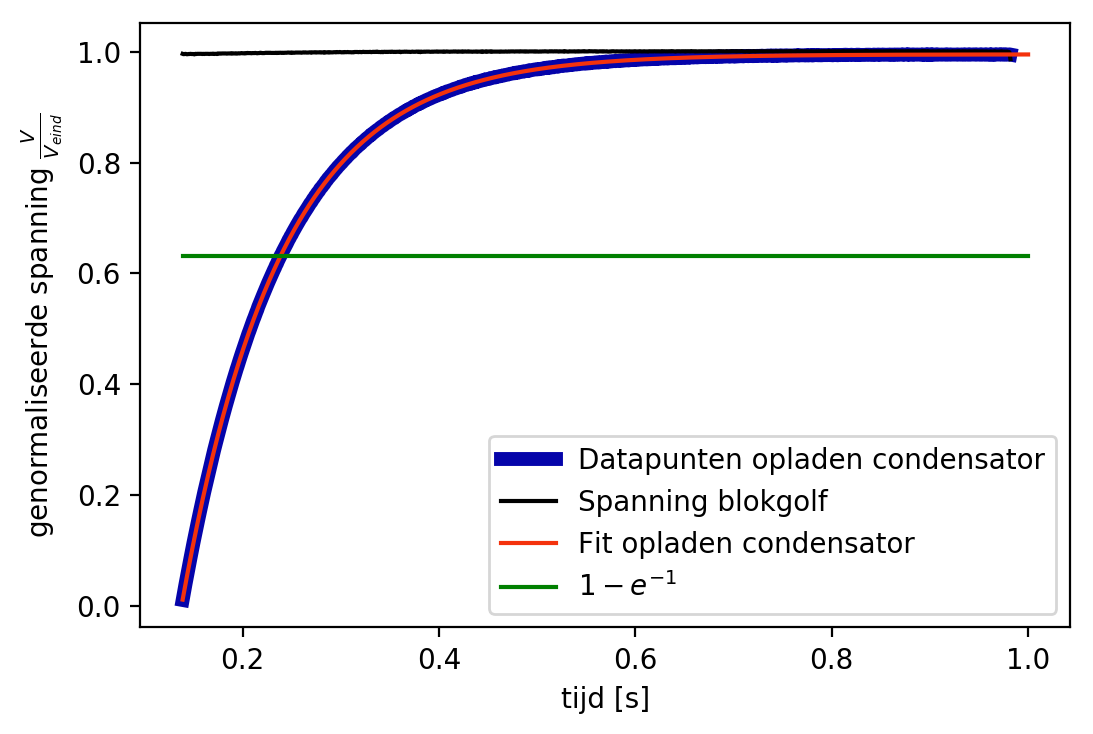

In [12]:
fig, ax = plt.subplots(1,1)

ax.plot(opladen[cols[0]], normalize(opladen[cols[1]].values, V_min, V_max), linewidth=5, color="xkcd:royal blue",
       label="Datapunten opladen condensator")
ax.plot(opladen[cols[0]], normalize(opladen[cols[2]].values, V_min, V_max), color='k',
       label="Spanning blokgolf")
T = np.linspace(np.min(opladen[cols[0]]), 1, 1000)
ax.plot(T, normalize(charge(T, *params), V_min, V_max), linewidth=1.5, color="xkcd:vermillion",
       label="Fit opladen condensator")
# lijn op 1-e^-1
Y = -np.expm1(-1)*np.ones_like(T)
ax.plot(T, Y, color='g', label=r"$1-e^{-1}$")

# lay-out
plt.legend()
ax.set_xlabel("tijd [s]")
ax.set_ylabel(r"genormaliseerde spanning $\frac{V}{V_{eind}}$")

plt.show()
fig.savefig("opladen.pdf")

### Bepalen tau

In [13]:
# snijpunt met de curve
# selecteer de punten tijdens het opladen waar de curve kleiner is dan 1-e-1
kleiner = opladen.loc[normalize(opladen[cols[1]], V_min, V_max) < -np.expm1(-1)]
groter = opladen.loc[normalize(opladen[cols[1]], V_min, V_max) > -np.expm1(-1)]
times1 = kleiner[cols[0]].values
times2 = groter[cols[0]].values
tau_min = times1[-1] - times1[0]
tau_max = times2[0] - times1[0]
display(tau_min, tau_max)

In [14]:
print("tau uit fit: %f +- %f" %(params[2], np.sqrt(covar[2][2])))

tau uit fit: 0.100213 +- 0.000008


## Ontladen condensator

In [15]:
# selecteer enkel de delen waar de condensator oplaadt
ontladen = frame.loc[(-5 > frame[cols[2]])]
# selecteer de eerste blokgolf
ontladen = ontladen.loc[(frame[cols[0]] < 2.5) & (frame[cols[0]] > 0.5)]

Fit de curve door de data

In [16]:
T = ontladen[cols[0]].values
V = ontladen[cols[1]].values
sigma = np.ones_like(T) * S_V
params, covar = opt.curve_fit(charge, T, V, (-8, 8, 0.1), sigma)

Normale plot

Genormaliseerde plot met lijn voor $1-e^{-1}$

In [17]:
def normalize(y, MIN, MAX):
    return (y-MIN)/(MAX-MIN)

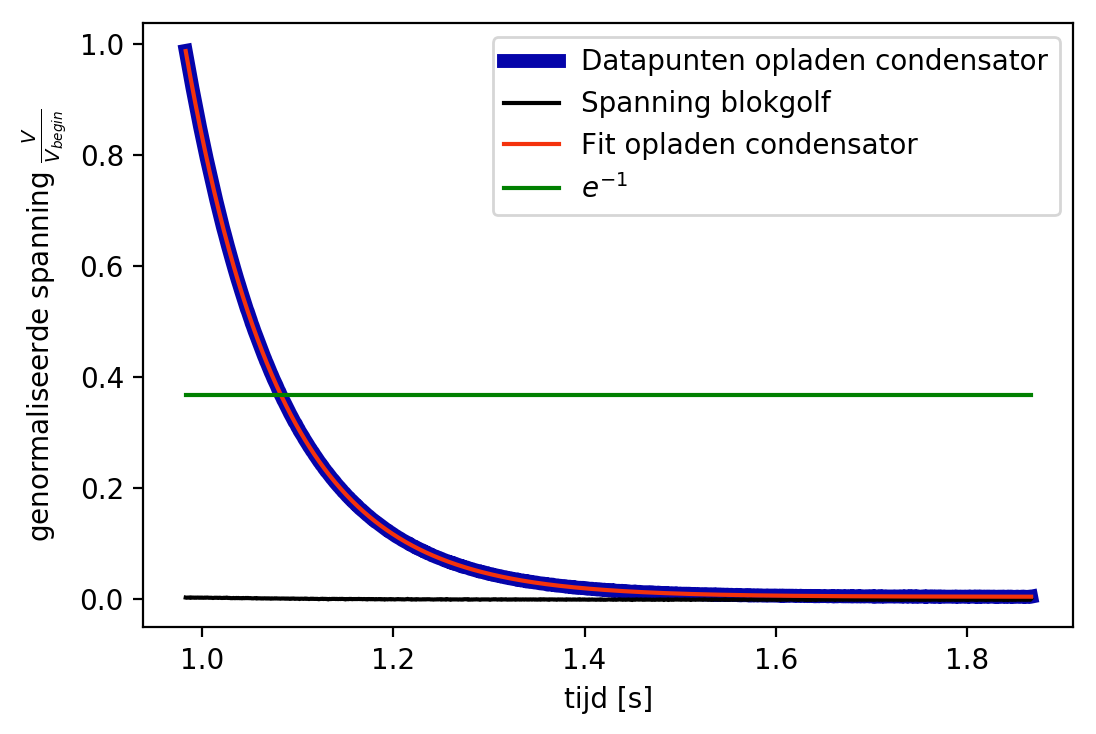

In [18]:
fig, ax = plt.subplots(1,1)

ax.plot(ontladen[cols[0]], normalize(ontladen[cols[1]].values, V_min, V_max), linewidth=5, color="xkcd:royal blue",
       label="Datapunten opladen condensator")
ax.plot(ontladen[cols[0]], normalize(ontladen[cols[2]].values, V_min, V_max), color='k',
       label="Spanning blokgolf")

ax.plot(T, normalize(charge(T, *params), V_min, V_max), linewidth=1.5, color="xkcd:vermillion",
       label="Fit opladen condensator")
# lijn op 1-e^-1
Y = np.exp(-1)*np.ones_like(T)
ax.plot(T, Y, color='g', label=r"$e^{-1}$")

# lay-out
plt.legend()
ax.set_xlabel("tijd [s]")
ax.set_ylabel(r"genormaliseerde spanning $\frac{V}{V_{begin}}$")

plt.show()

fig.savefig("Ontladen.pdf")

### Bepalen tau

In [19]:
# snijpunt met de curve
# selecteer de punten tijdens het opladen waar de curve kleiner is dan 1-e-1
kleiner = ontladen.loc[normalize(ontladen[cols[1]], V_min, V_max) < np.exp(-1)]
groter = ontladen.loc[normalize(ontladen[cols[1]], V_min, V_max) > np.exp(-1)]
times1 = kleiner[cols[0]].values
times2 = groter[cols[0]].values
tau_min = times1[0] - times2[0]
tau_max = times2[-1] - times2[0]
display(tau_min, tau_max)

In [20]:
params

array([ 2.66743687e+05, -6.97468201e+00,  1.00081098e-01])

In [21]:
print("tau uit fit: %f +- %f" %(params[2], np.sqrt(covar[2][2])))

tau uit fit: 0.100081 +- 0.000008


### tau uit gegeven waardes 

In [22]:
R, C, S_R, S_C = sp.symbols('R, C, S_R, S_C')
tau = (R*C)
S_tau = error(tau, [R, C], [S_R, S_C])
subs = {R : 1e4, C : 10e-6, S_R : 5e2, S_C : 5e-7}
display(tau.subs(subs), S_tau.subs(subs))

## reactie CR-keten op sinusgolf

### Importeren data

In [23]:
nums = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
       150, 160, 170, 180, 200, 300, 400, 500]
frames = [pd.read_csv("data_gekuist/CR%d.csv" %num) for num in nums]
# zet alles in milliseconden
frames[0][frames[0].columns[0]] *= 1000
frames[1][frames[1].columns[0]] *= 1000

### fitten curves

De te fitten sinusfunctie

In [24]:
def spanning(t, omega, phi, A):
    return A*np.sin(omega*t/1000-phi)

Fit voor elke plot beide functies

In [25]:
params1 = {i : [] for i in nums}
covars1 = {i : [] for i in nums}
params2 = {i : [] for i in nums}
covars2 = {i : [] for i in nums}


for i in range(24):
    num = nums[i]
    frame = frames[i]
    T = frame[frame.columns[0]]
    V1 = frame[frame.columns[1]]
    V2 = frame[frame.columns[2]]
    param1, covar1 = opt.curve_fit(spanning, T, V1, (num*2*np.pi, 0, 5))
    param2, covar2 = opt.curve_fit(spanning, T, V2, (num*2*np.pi, 0, 8))
    params1[num] = param1
    params2[num] = param2
    covars1[num] = covar1
    covars2[num] = covar2
    
# fiks de voorlaatste fit
num = nums[22]
frame = frames[22]
T = frame[frame.columns[0]]
V1 = frame[frame.columns[1]]
V2 = frame[frame.columns[2]]
param1, covar1 = opt.curve_fit(spanning, T, V1, (num*2*np.pi, 10, 5))
param2, covar2 = opt.curve_fit(spanning, T, V2, (num*2*np.pi, 10, 8))
params1[num] = param1
params2[num] = param2
covars1[num] = covar1
covars2[num] = covar2

In [26]:
# fix the signs of all variables (should all be positive)
for num in nums:
    for param in [params1[num], params2[num]]:
        if param[0] < 0:
            # switch sign of argument and amplitude to fix sign of omega
            param[0] *= -1
            param[1] *= -1
            param[2] *= -1
        if param[1] < 0:
            # add multiples of 2*pi so it becomes positive
            n = np.ceil(-param[1]/(2*np.pi))
            param[1] += n*2*np.pi
        if param[2] < 0:
            # add pi to phase to fix sign of amplitude
            param[2] *= -1
            param[1] += np.pi
        param[1] = param[1] % (2*np.pi)

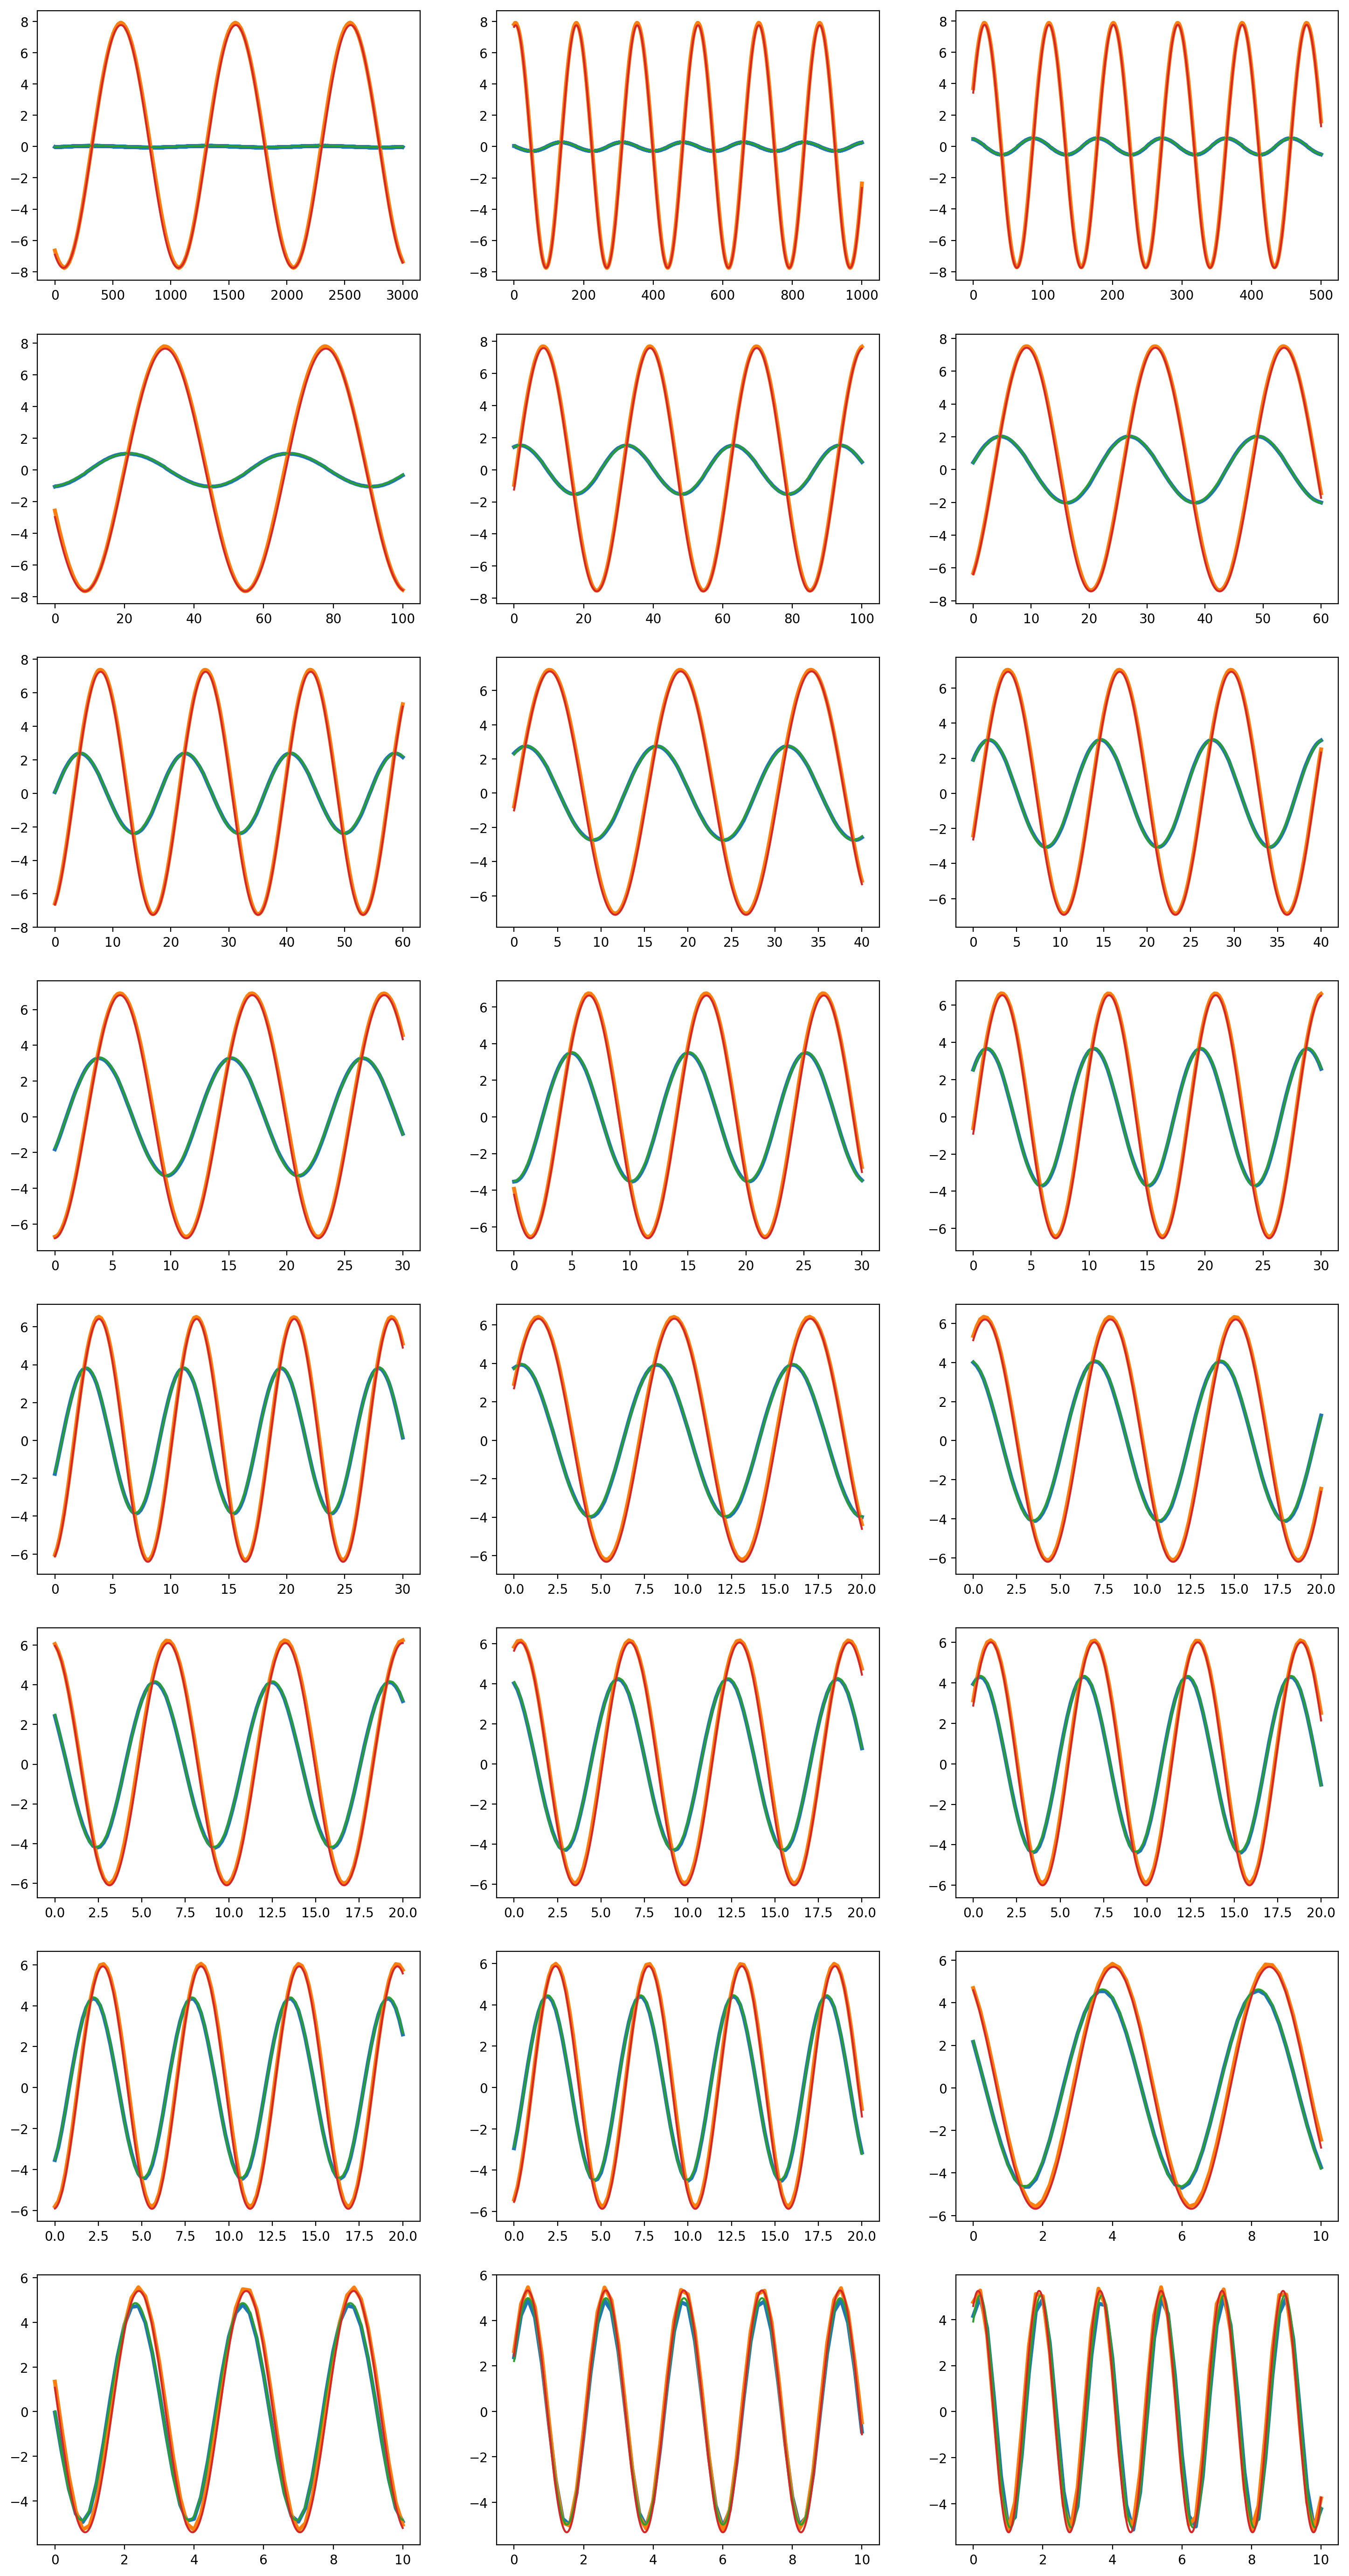

In [27]:
fig, axes = plt.subplots(8,3, figsize=(18, 36))

for i in range(24):
    num = nums[i]
    frame = frames[i]
    cols = frame.columns
    
    ax = axes[i//3][i%3]

    ax.plot(frame[cols[0]], frame[cols[1]], linewidth=3)
    ax.plot(frame[cols[0]], frame[cols[2]], linewidth=3)
    T = np.linspace(np.min(frame[cols[0]]), np.max(frame[cols[0]]), 1000)
    ax.plot(T, spanning(T, *params1[num]))
    ax.plot(T, spanning(T, *params2[num]))

plt.show()

#fig.savefig("CR-circuit-frequenties.png")

fix the relative position of the phases, the second one should be the bigger one!

In [28]:
for num in nums[:-2]:
    if params1[num][1] > params2[num][2]:
        params1[num][1] -= np.pi
        params2[num][1] += np.pi

In [29]:
temp = params2[nums[-2]][1]
params2[nums[-2]][1] = params1[nums[-2]][1]
params1[nums[-2]][1] = temp
temp = params2[nums[-1]][1]
params2[nums[-1]][1] = params1[nums[-1]][1]
params1[nums[-1]][1] = temp

Plot van amplitude uit Vs frequentie

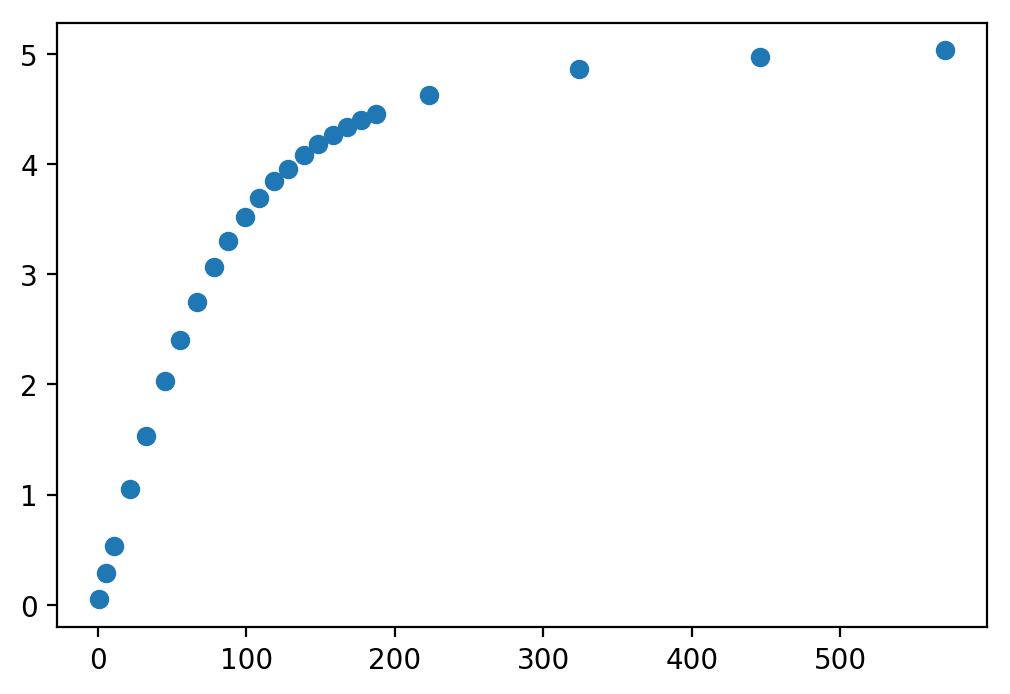

In [30]:
fig, ax = plt.subplots(1,1)
frequencies = np.array([np.abs(params1[num][0])/(2*np.pi) for num in nums])
amplitudes = np.array([np.abs(params1[num][2]) for num in nums])

ax.plot(frequencies, amplitudes, 'o')

plt.show()

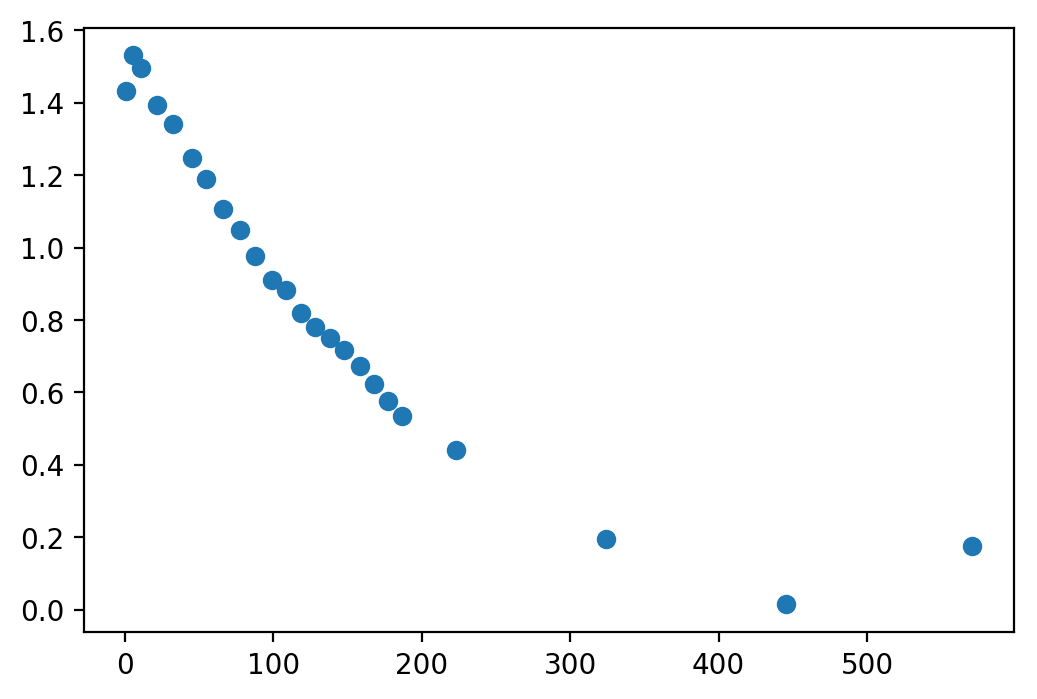

In [31]:
fig, ax = plt.subplots(1,1)

ax.plot([np.abs(params1[num][0]/(2*np.pi)) for num in nums[:]], [(params2[num][1] - params1[num][1]) %(2*np.pi) for num in nums[:]], 'o')

plt.show()

### Fitten data CR-circuit

In [32]:
# de functie om door de amplitude te fitten
def V_out(f, V_in, RC):
    return V_in*2*np.pi*f*RC/np.sqrt(1 + (2*np.pi*f*RC)**2)

In [33]:
# fit de data van de amplitude
param, covar = opt.curve_fit(V_out, frequencies, amplitudes, (5, 200))

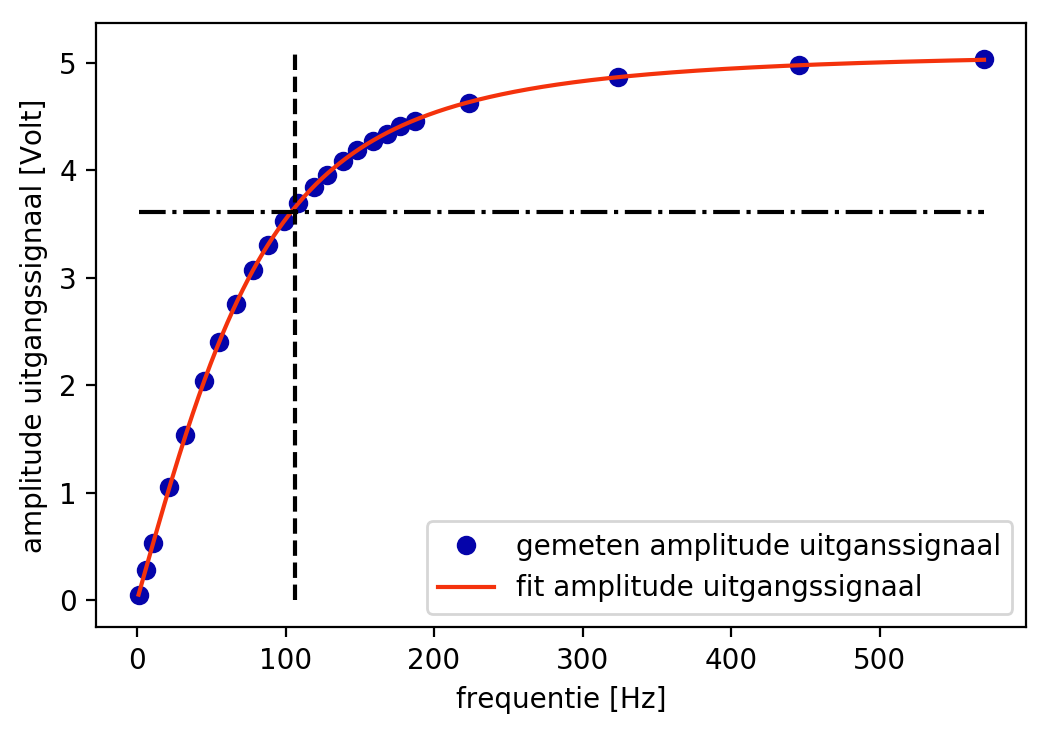

In [34]:
fig, ax = plt.subplots(1,1)

cutoff = 106.103

ax.plot(frequencies, amplitudes, 'o', color="xkcd:royal blue", 
        label="gemeten amplitude uitganssignaal")

F = np.linspace(np.min(frequencies), np.max(frequencies), 1000)
ax.plot(F, V_out(F, *param), color="xkcd:vermillion", label="fit amplitude uitgangssignaal")

# plot lijnen voor cutoff en 1/sqrt(2)
ax.plot([cutoff, cutoff], [0, param[0]], "--k")
ax.plot([np.min(frequencies), np.max(frequencies)], [1/np.sqrt(2)*param[0], 1/np.sqrt(2)*param[0]], 
        "-.k")

# layout
ax.set_xlabel("frequentie [Hz]")
ax.set_ylabel("amplitude uitgangssignaal [Volt]")
plt.legend()

plt.show()
fig.savefig("CR_amplitude.pdf")

### berkenen van $\tau$ uit de fit 

In [35]:
RC, S_RC = sp.symbols('RC, S_RC')
f = 1/(2*np.pi*RC)
cut = f.subs({RC : param[1]})
s_cut = error(f, [RC], [S_RC]).subs({RC : param[1], S_RC : np.sqrt(covar[1,1])})
display(cut, s_cut)

In [36]:
display(f.subs({RC : 1.5e-3}), error(f, [RC], [S_RC]).subs({RC : 1.5e-3, S_RC : np.sqrt((15e-6*5)**2 + (100*5e-7)**2)}))

print de gevonden waarde voor R*C uit de fit

In [37]:
print("RC: %f +- %f" %(param[1], np.sqrt(covar[1,1])))

RC: 0.001531 +- 0.000002


## Fasefit

In [38]:
def fase(f, RC):
    omega = 2*np.pi*f
    return np.arctan(1/(omega*RC))

In [39]:
F = np.array([np.abs(params1[num][0]/(2*np.pi)) for num in nums[:]])
P = np.array([(params2[num][1] - params1[num][1]) %(2*np.pi) for num in nums[:]])
param, covar = opt.curve_fit(fase, F, P, (100))

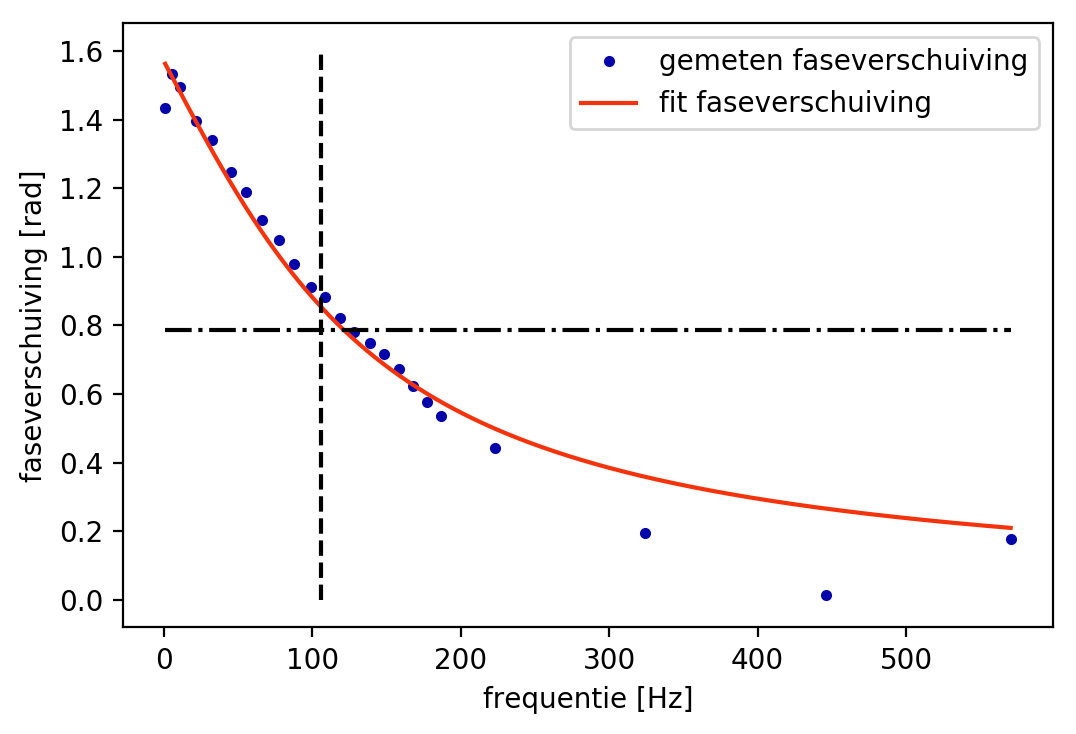

In [40]:
fig, ax = plt.subplots(1,1)

ax.plot(F, P, '.', color="xkcd:royal blue", label="gemeten faseverschuiving")

X = np.linspace(np.min(F), np.max(F), 1000)
ax.plot(X, fase(X, *param), color="xkcd:vermillion", label="fit faseverschuiving")
#ax.plot(X, fase(X, 0.0015), color="k", label="gok faseverschuiving")

# plot lijnen voor berekende cut-off
ax.plot([cutoff, cutoff], [0, 1.6], "--k")
ax.plot([np.min(frequencies), np.max(frequencies)], [np.pi/4, np.pi/4], "-.k")

ax.set_xlabel("frequentie [Hz]")
ax.set_ylabel("faseverschuiving [rad]")
plt.legend()

plt.show()

fig.savefig("CR_fase.pdf")

### berkenen van $\tau$ uit de fit 

In [41]:
RC, S_RC = sp.symbols('RC, S_RC')
f = 1/(2*np.pi*RC)
cut = f.subs({RC : param[0]})
s_cut = error(f, [RC], [S_RC]).subs({RC : param[0], S_RC : np.sqrt(covar[0,0])})
display(cut, s_cut)

In [42]:
print("waarde voor RC uit faseverschuiving: %f +- %f" %(param[0], np.sqrt(covar[0][0])))

waarde voor RC uit faseverschuiving: 0.001309 +- 0.000051


## Data RLC circuit

### Invoeren data

In [43]:
freqs15 = np.array([5000, 7500, 10_000, 15_000, 20_000, 18_000, 17_000, 21_000, 27_000, 30_000, 40_000,
                   100_000, 60_000])
S_freqs15 = np.array([250, 250, 250, 250, 250, 250, 250, 2500, 2500, 2500, 2500, 2500, 2500])
amp15 = np.array([5, 6, 6.5, 7, 11, 9.5, 8.5, 14, 26, 13.5, 4, 0, 2])
S_amp15 = 0.5*np.ones_like(amp15)

In [44]:
freqs33 = np.array([10000, 20000, 30000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 90000])
S_freqs33 = 2500*np.ones_like(freqs33)
amp33 = np.array([3, 3, 4, 4.5, 6, 10, 16, 14.5, 7, 4.5, 2])
S_amp33 = 0.5*np.ones_like(amp33)

### plots to check data

### Fitten resonantiepiek

In [57]:
def amp_out(f, C, R, IN, L):
    omega = 2*np.pi*f
    return IN*(1/omega*C)*1/np.sqrt(R**2 + (omega*L-1/(omega*C))**2)

In [58]:
# fitten data lagere frequentie
param15, covar15 = opt.curve_fit(amp_out, freqs15, amp15, (15e-9, 80, 5e16, 2.5e-3), S_amp15)

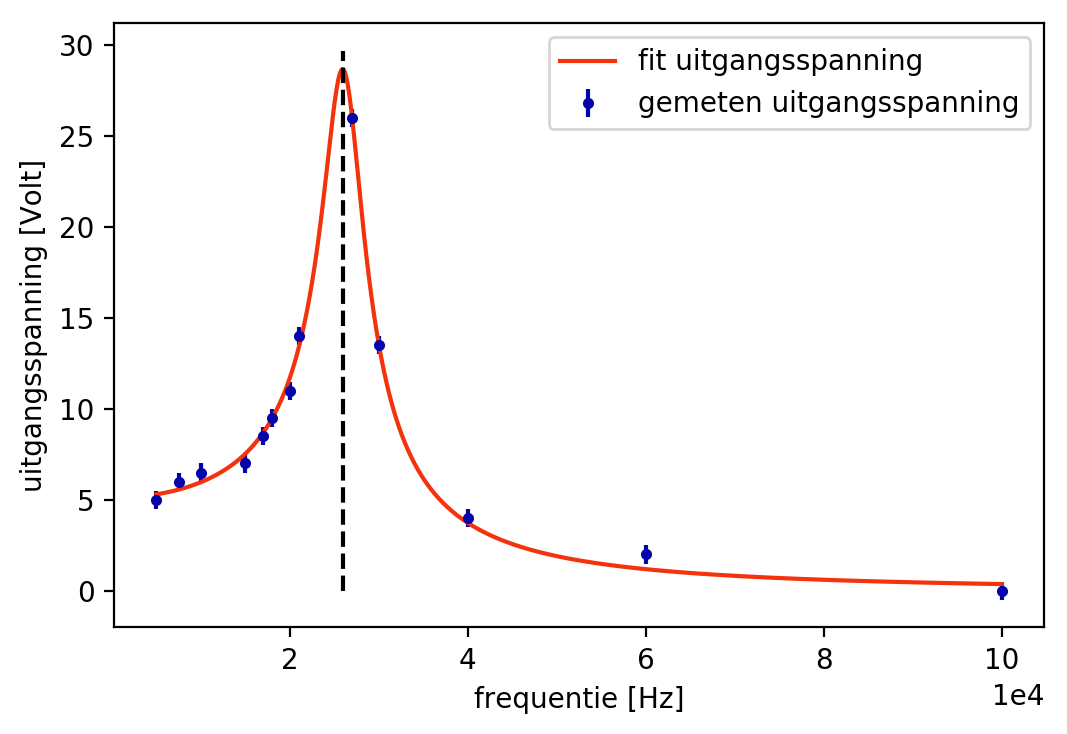

In [59]:
fig, ax = plt.subplots(1,1)

resonantie = 2.598989337e4

ax.errorbar(freqs15, amp15, S_amp15, fmt='.', color="xkcd:royal blue", label="gemeten uitgangsspanning")
F = np.linspace(np.min(freqs15), np.max(freqs15), 1000)
Y = amp_out(F, *param15)
ax.plot(F, Y, color="xkcd:vermillion", label="fit uitgangsspanning")
ax.plot([resonantie, resonantie], [0, np.max(Y)+1], "--k")

plt.legend()
ax.set_xlabel("frequentie [Hz]")
ax.set_ylabel("uitgangsspanning [Volt]")
ax.ticklabel_format(axis="x", style="sci", scilimits=(4,4))

plt.show()
fig.savefig("RLC_resonantie_1.pdf")

In [60]:
param15

array([1.73686355e-08, 6.27824934e+01, 1.69516079e+16, 2.13386439e-03])

In [48]:
print("capaciteit: %e +- %e, inductantie: %e +- %e" %(param15[0], np.sqrt(-covar15[0,0]), 
                                                      param15[3], np.sqrt(-covar15[3,3])))

capaciteit: 1.736864e-08 +- 1.088402e-02, inductantie: 2.133864e-03 +- 1.337181e+03


### theoretische resonantiefreque

In [49]:
C, L, S_C, S_L = sp.symbols("C, L, S_C, S_L")
f = sp.sqrt(1/(C*L))/(2*np.pi)
S_f = error(f, [C, L], [S_C, S_L])

Theoretische resonantiefrequentie

In [50]:
subs = {C : 15e-9, L : 2.5e-3, S_C : 0.5e-9, S_L : 1e-4}
display(f.subs(subs), S_f.subs(subs))

resonantiefrequentie uit fit

In [51]:
subs = {C : param15[0], L : np.sqrt(-covar15[0,0]), S_C : param15[3], S_L : np.sqrt(-covar15[3,3])}
display(f.subs(subs), S_f.subs(subs))

### hogere resonantiefrequentie

In [52]:
# fitten data lagere frequentie
param33, covar33 = opt.curve_fit(amp_out, freqs33, amp33, (3.3e-9, 80, 5e16, 2.5e-3), S_amp33)

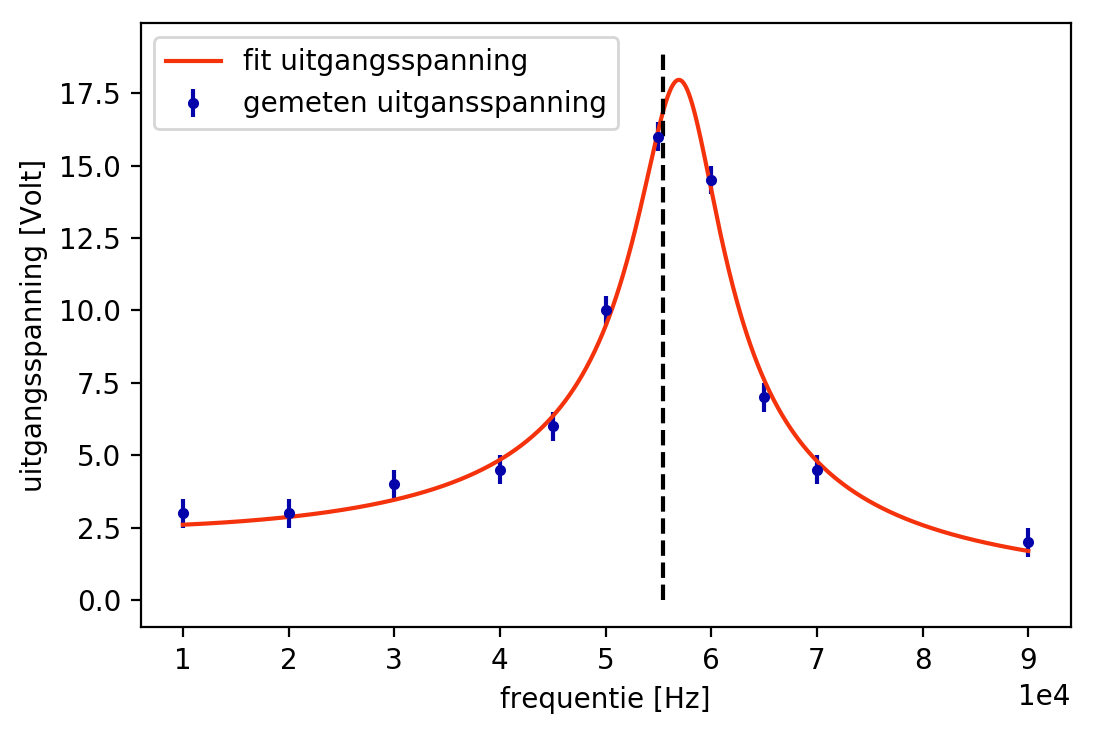

In [53]:
fig, ax = plt.subplots(1,1)

resonantie = 5.541063885e4

ax.errorbar(freqs33, amp33, S_amp33, fmt='.', color="xkcd:royal blue", label="gemeten uitgansspanning")
F = np.linspace(np.min(freqs33), np.max(freqs33), 1000)
Y = amp_out(F, *param33)
ax.plot(F, Y, color="xkcd:vermillion", label="fit uitgangsspanning")
ax.plot([resonantie, resonantie], [0, np.max(Y)+1], "--k")

plt.legend(loc="upper left")
ax.set_xlabel("frequentie [Hz]")
ax.set_ylabel("uitgangsspanning [Volt]")
ax.ticklabel_format(axis="x", style="sci", scilimits=(4,4))

plt.show()
fig.savefig("RLC_resonantie_2.pdf")

In [61]:
param33

array([3.60857717e-09, 1.08444120e+02, 1.93539221e+17, 2.14378633e-03])

In [54]:
subs = {C : 3.3e-9, L : 2.5e-3, S_C : 0.1e-9, S_L : 1e-4}
display(f.subs(subs), S_f.subs(subs))

resonantiefrequentie uit fit

In [55]:
subs = {C : param33[0], L : np.sqrt(covar33[0,0]), S_C : param33[3], S_L : np.sqrt(covar33[3,3])}
display(f.subs(subs), S_f.subs(subs))

In [56]:
print("capaciteit: %e +- %e, inductantie: %e +- %e" %(param33[0], np.sqrt(covar33[0,0]), 
                                                      param33[3], np.sqrt(covar33[3,3])))

capaciteit: 3.608577e-09 +- 1.724529e-03, inductantie: 2.143786e-03 +- 1.024510e+03


### Fit equation for amplitude through datapoints

nums = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
       150, 160, 170, 180, 200, 300, 400, 500]

for num in nums:
    temp = pd.read_csv("data/CR%d.csv" %num, sep=";", decimal=",")
    cols = temp.columns
    i = 0
    frame = temp[[cols[3*i], cols[3*i+1], cols[3*i+2]]]
    frame = frame.dropna()
    frame.to_csv("data_gekuist/CR%d.csv" %num, index=False)